In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
import random
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from sklearn.model_selection import KFold

#then import my own modules
# from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight
from timeit import default_timer as timer
from AttentiveFP.featurizing import graph_dict
from AttentiveFP.AttentiveLayers_new3 import Fingerprint, graph_dataset, null_collate, Graph, Logger, time_to_str



In [2]:
cuda_aviable = torch.cuda.is_available()
device = torch.device(0)

SEED = 8
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic=True


In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer

In [4]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score


number of all smiles:  2050
failed to process smiles:  O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3
failed to process smiles:  c1(nc(NC(N)=[NH2])sc1)CSCCNC(=[NH]C#N)NC
failed to process smiles:  Cc1nc(sc1)\[NH]=C(\N)N
failed to process smiles:  s1cc(CSCCN\C(NC)=[NH]\C#N)nc1\[NH]=C(\N)N
failed to process smiles:  c1c(c(ncc1)CSCCN\C(=[NH]\C#N)NCC)Br
failed to process smiles:  n1c(csc1\[NH]=C(\N)N)c1ccccc1
failed to process smiles:  n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N
failed to process smiles:  n1c(csc1\[NH]=C(\N)N)c1cccc(c1)NC(C)=O
failed to process smiles:  n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N\C(NC)=[NH]\C#N
failed to process smiles:  s1cc(nc1\[NH]=C(\N)N)C
failed to process smiles:  c1(cc(N\C(=[NH]\c2cccc(c2)CC)C)ccc1)CC
number of successfully processed smiles:  2039


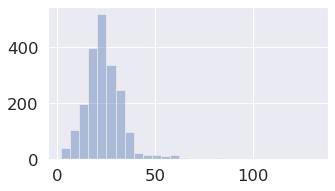

In [5]:
task_name = 'BBBP'
tasks = ['BBBP']
raw_filename = "../data/BBBP.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("failed to process smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()


In [6]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 50
epochs = 200

p_dropout= 0.2
fingerprint_dim = 32

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2.5
K = 2
T = 2
per_task_output_units_num = 2 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [7]:
smiles_list = smiles_tasks_df['smiles'].values
label_list = smiles_tasks_df[tasks[0]].values
graph_dict = graph_dict(smiles_list, label_list, filename)


graph dicts saved as ../data/BBBP.pkl


In [8]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

class ScaffoldGenerator(object):
    """
    Generate molecular scaffolds.

    Parameters
    ----------
    include_chirality : : bool, optional (default False)
      Include chirality in scaffolds.
    """

    def __init__(self, include_chirality=False):
        self.include_chirality = include_chirality

    def get_scaffold(self, mol):
        """
        Get Murcko scaffolds for molecules.

        Murcko scaffolds are described in DOI: 10.1021/jm9602928. They are
        essentially that part of the molecule consisting of rings and the
        linker atoms between them.

        Parameters
        ----------
        mols : array_like
            Molecules.
        """
        return MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=self.include_chirality)


def generate_scaffold(smiles, include_chirality=False):
    mol = Chem.MolFromSmiles(smiles)
    engine = ScaffoldGenerator(include_chirality=include_chirality)
    scaffold = engine.get_scaffold(mol)
    return scaffold


In [9]:
weights = []
for i,task in enumerate(tasks):    
    negative_df = smiles_tasks_df[smiles_tasks_df[task] == 0][["smiles",task]]
    positive_df = smiles_tasks_df[smiles_tasks_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])
    
scaffold_list = []
all_scaffolds_dict = {}

for index, smiles in enumerate(smiles_tasks_df['smiles']):
    scaffold = generate_scaffold(smiles)
    scaffold_list.append(scaffold)
    if scaffold not in all_scaffolds_dict:
        all_scaffolds_dict[scaffold] = [index]
    else:
        all_scaffolds_dict[scaffold].append(index)
smiles_tasks_df['scaffold'] = scaffold_list


In [10]:
smiles_tasks_df.groupby(['scaffold'])['scaffold'].count() \
                     .reset_index(name='count') \
                     .sort_values(['count'], ascending=False) \
                     .head(10)

,scaffold,count
995,c1ccccc1,137
0,,99
379,O=C1C=CC2C(=C1)CCC1C3CCCC3CCC21,76
949,c1ccc2c(c1)Nc1ccccc1S2,26
498,O=C1CN=C(c2ccccc2)c2ccccc2N1,26
357,O=C1C=C2CCC3C4CCCC4CCC3C2CC1,24
837,c1ccc(Cc2ccccc2)cc1,21
400,O=C1CC(=O)NC(=O)N1,18
201,O=C(Cc1ccccc1)N1CCNCC1CN1CCCC1,17
998,c1ccncc1,16


In [11]:
def scaffold_randomized_spliting(scaffolds_dict, sample_size, random_seed = 0): 
    count = 0
    minor_count = 0
    minor_class = np.argmax(weights[0]) # weights are inverse of the ratio
    minor_ratio= 1/weights[0][minor_class]
    optimal_count = 0.1*len(smiles_tasks_df)
    while (count < optimal_count*0.9 or  count > optimal_count*1.1) \
        or (minor_count < minor_ratio*optimal_count*0.9 \
            or  minor_count > minor_ratio*optimal_count*1.1):
        random_seed +=1
        random.seed(random_seed)
        scaffold = random.sample(list(scaffolds_dict.keys()), sample_size)
        count = sum([len(scaffolds_dict[scaffold]) for scaffold in scaffold])
        index = [index for scaffold in scaffold for index in scaffolds_dict[scaffold]]
        minor_count = len(smiles_tasks_df.iloc[index, :][smiles_tasks_df[tasks[0]] == minor_class])
#     print(random)
    print(random_seed, count, minor_count, index)
    return scaffold, index

samples_size = int(len(all_scaffolds_dict.keys())*0.1)
print(samples_size)
test_scaffold, test_index = scaffold_randomized_spliting(all_scaffolds_dict, samples_size, random_seed=8)
training_scaffolds_dict = {x: all_scaffolds_dict[x] for x in all_scaffolds_dict.keys() if x not in test_scaffold}
valid_scaffold, valid_index = scaffold_randomized_spliting(training_scaffolds_dict, samples_size, random_seed=8)


102
20 190 45 [544, 1020, 1315, 1242, 1358, 1462, 1465, 1940, 1941, 1952, 1646, 1793, 143, 1693, 625, 1123, 1797, 244, 429, 548, 575, 652, 1296, 1731, 1887, 1956, 29, 821, 931, 1216, 814, 102, 146, 842, 882, 893, 179, 324, 596, 598, 945, 1018, 1531, 1915, 1140, 900, 1996, 319, 301, 1346, 592, 992, 1214, 1804, 1326, 641, 626, 859, 129, 1218, 1017, 1562, 1623, 975, 812, 111, 317, 2008, 390, 38, 307, 360, 131, 113, 1616, 1889, 286, 1525, 411, 1362, 1483, 482, 553, 568, 646, 702, 1413, 1783, 1920, 1353, 1585, 416, 236, 1212, 169, 2005, 25, 48, 58, 114, 275, 325, 357, 560, 561, 611, 612, 642, 1401, 1402, 1568, 1860, 437, 651, 1199, 1724, 1384, 367, 1926, 1660, 1955, 344, 693, 1125, 1280, 373, 1088, 1089, 1726, 1884, 72, 82, 334, 338, 13, 313, 1550, 1261, 1262, 1204, 535, 1352, 1587, 1998, 475, 197, 1363, 1542, 1264, 1971, 1172, 1409, 1787, 897, 899, 901, 1798, 220, 550, 630, 1097, 1106, 1249, 466, 1086, 1603, 868, 912, 225, 237, 678, 953, 1042, 1637, 1639, 1937, 813, 1385, 1670, 1903, 1930,

/data2/erikxiong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [12]:
test_df = smiles_tasks_df.iloc[test_index,:] # test set
valid_df = smiles_tasks_df.iloc[valid_index,:] # valid set
train_df = smiles_tasks_df.drop(test_df.index).drop(valid_df.index) # train set
test_smiles = test_df.smiles.values
valid_smiles = valid_df.smiles.values
train_smiles = train_df.smiles.values

In [13]:
loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]

model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
model.to(device)

optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in  model.parameters()])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

76998
preprocess.0.linear.weight torch.Size([32, 39])
preprocess.0.linear.bias torch.Size([32])
preprocess.0.bn.weight torch.Size([32])
preprocess.0.bn.bias torch.Size([32])
propagate.0.encoder.0.linear.weight torch.Size([1024, 10])
propagate.0.encoder.0.linear.bias torch.Size([1024])
propagate.0.encoder.0.bn.weight torch.Size([1024])
propagate.0.encoder.0.bn.bias torch.Size([1024])
propagate.0.align.weight torch.Size([1, 64])
propagate.0.align.bias torch.Size([1])
propagate.0.attend.linear.weight torch.Size([32, 32])
propagate.0.attend.linear.bias torch.Size([32])
propagate.0.attend.bn.weight torch.Size([32])
propagate.0.attend.bn.bias torch.Size([32])
propagate.0.gru.weight_ih torch.Size([96, 32])
propagate.0.gru.weight_hh torch.Size([96, 32])
propagate.0.gru.bias_ih torch.Size([96])
propagate.0.gru.bias_hh torch.Size([96])
propagate.1.encoder.0.linear.weight torch.Size([1024, 10])
propagate.1.encoder.0.linear.bias torch.Size([1024])
propagate.1.encoder.0.bn.weight torch.Size([1024])

In [14]:
def train(model, smiles_list):
    model.train()
    train_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=True, worker_init_fn=np.random.seed(SEED),drop_last=True)
    losses = []
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(train_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
#         label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            
            validInds = np.where((label==0) | (label==1))[0]
#             validInds = np.where(label != -1)[0]
            if len(validInds) == 0:
                continue
            label_adjust = np.array([label[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(label_adjust))
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return np.mean(losses)

        
def eval(model, smiles_list):
    model.eval()
    label_list = {}
    y_pred_list = {}
    losses_list = []
    eval_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(eval_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
#         label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]

            validInds = np.where((label==0) | (label==1))[0]
#             validInds = np.where((label=='0') | (label=='1'))[0]
            if len(validInds) == 0:
                continue
            label_adjust = np.array([label[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(label_adjust))
            
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                label_list[i].extend(label_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                label_list[i] = []
                y_pred_list[i] = []
                label_list[i].extend(label_adjust)
                y_pred_list[i].extend(y_pred_adjust)
                
    eval_roc = [roc_auc_score(label_list[i], y_pred_list[i]) for i in range(len(tasks))]
#     eval_prc = [auc(precision_recall_curve(label_list[i], y_pred_list[i])[1],precision_recall_curve(label_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     eval_precision = [precision_score(label_list[i],
#                                      (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
#     eval_recall = [recall_score(label_list[i],
#                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    eval_loss = np.array(losses_list).mean()
    
    return eval_roc, eval_loss #eval_prc, eval_precision, eval_recall, 


In [15]:
log = Logger()
log.open(f'{prefix_filename}_{start_time}.txt')

f = '{:^5} | {:^6.4f} | {:^10.4f} | {:^10.4f} | {:^9.4f} | {:^9.4f} | {:^10} |\n'
log.write('epoch | losses | train loss | valid loss | train roc |  valid roc |   time  |\n')
start = timer()

best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    losses = train(model, train_smiles)
    train_roc, train_loss = eval(model, train_smiles)
    valid_roc, valid_loss = eval(model, valid_smiles)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
    timing = time_to_str((timer() - start), 'min')  
    log.write(f.format(epoch, losses, train_loss, valid_loss, train_roc_mean, valid_roc_mean, timing))

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.80:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    if (epoch - best_param["roc_epoch"] >8) and (epoch - best_param["loss_epoch"] >18):        
        break
        
print(best_param["roc_epoch"],best_param["loss_epoch"],best_param["valid_roc"])



epoch |  losses  | train loss |  valid loss | train roc |  valid roc |  time 
  0   | 0.5365  | 0.5928  | 0.8019  | 0.8409  | 0.9096  |  0 hr 00 min 
  1   | 0.4355  | 0.5132  | 0.4109  | 0.8973  | 0.9085  |  0 hr 00 min 
  2   | 0.4096  | 0.4130  | 0.3958  | 0.9304  | 0.9097  |  0 hr 00 min 
  3   | 0.3885  | 0.3090  | 0.4240  | 0.9402  | 0.9033  |  0 hr 00 min 
  4   | 0.3617  | 0.2778  | 0.4268  | 0.9509  | 0.8973  |  0 hr 00 min 
  5   | 0.3398  | 0.2776  | 0.5259  | 0.9518  | 0.8617  |  0 hr 00 min 
  6   | 0.3511  | 0.3869  | 0.3834  | 0.9336  | 0.9122  |  0 hr 00 min 
  7   | 0.3403  | 0.2906  | 0.4133  | 0.9489  | 0.9119  |  0 hr 00 min 
  8   | 0.3527  | 0.2720  | 0.5203  | 0.9561  | 0.8647  |  0 hr 00 min 
  9   | 0.3119  | 0.2526  | 0.4964  | 0.9596  | 0.8878  |  0 hr 00 min 
 10   | 0.2809  | 0.2441  | 0.3789  | 0.9673  | 0.9281  |  0 hr 01 min 
 11   | 0.3149  | 0.2708  | 0.4545  | 0.9528  | 0.9158  |  0 hr 01 min 
 12   | 0.2981  | 0.2572  | 0.3686  | 0.9712  | 0.9201  | 

In [16]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')     

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()

test_roc, test_losses = eval(best_model, test_smiles)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

best epoch:14
test_roc:[0.8500383141762452]
test_roc_mean: 0.8500383141762452
